In [91]:
import numpy as np
import pandas as pd
import seaborn as sns

import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
from scipy import stats

import datashader as ds
from datashader.mpl_ext import dsshow

from numpy.random import default_rng
from collections import Counter
import itertools

from sklearn.decomposition import PCA

import tensorflow as tf

In [41]:
adata_atac = ad.read_h5ad('write/filtered_data_atac.h5ad')
adata_gex = ad.read_h5ad('write/filtered_data_gex.h5ad')

In [42]:
# splitting via site/donor

#train_gex = adata_gex[adata_gex.obs.Samplename != 'site1_donor1_multiome']
#test_gex = adata_gex[adata_gex.obs.Samplename == 'site1_donor1_multiome']

In [43]:
# shuffle data
np.random.seed(100)
random_permutation = np.random.permutation(adata_atac.shape[0])
adata_atac = adata_atac[random_permutation,:]
adata_gex = adata_gex[random_permutation,:]

In [44]:
# split data into train and test set, 

test_indices = []
test_split = 0.1

cell_types = Counter(adata_gex.obs.cell_type)
for c_type in list(cell_types.keys()):
    mask = adata_gex.obs.cell_type == c_type
    test_index = list(adata_gex[mask].obs.index[0:int(test_split*cell_types[c_type])])
    test_indices.append(test_index)

test_indices = list(itertools.chain(*test_indices))
train_indices = adata_gex.obs.index.drop(test_indices)

train_atac = adata_atac[train_indices,:]
train_gex = adata_gex[train_indices,:]

test_atac = adata_atac[test_indices,:]
test_gex = adata_gex[test_indices,:]

In [45]:
# split data radnomly in train and test data
#cell_count = adata_gex.shape[0]

#rng = default_rng()
#test_index = np.sort(rng.choice(cell_count, size=int(0.1*cell_count), replace=False))
#train_index = np.delete(np.arange(cell_count), test_index)

# split data (not randomly) in train and test data
#test_index = np.arange(int(0.1*cell_count))
#train_index = np.arange(int(0.1*cell_count), cell_count)

#train_atac = adata_atac[train_index,:]
#train_gex = adata_gex[train_index,:]

#test_atac = adata_atac[test_index,:]
#test_gex = adata_gex[test_index,:]

In [46]:
# GEX data is already normalized and logarithmized

In [47]:
# do PCA?

In [48]:
# build model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = (train_atac.shape[1],)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(8192, activation = 'relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(4096, activation = 'relu'),
    tf.keras.layers.Dense(2048, activation = 'relu', name = 'output')
])

In [49]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_6 (Dropout)         (None, 32768)             0         
                                                                 
 dense_6 (Dense)             (None, 8192)              268443648 
                                                                 
 dropout_7 (Dropout)         (None, 8192)              0         
                                                                 
 dense_7 (Dense)             (None, 4096)              33558528  
                                                                 
 output (Dense)              (None, 2048)              8390656   
                                                                 
Total params: 310,392,832
Trainable params: 310,392,832
Non-trainable params: 0
_________________________________________________________________


In [50]:
model.compile(optimizer='adam',
            loss = tf.keras.losses.MeanSquaredError(),
            metrics = [tf.keras.metrics.RootMeanSquaredError()])

# no metrics needed: loss works to evaluate network (loss here meansquarederror)
# loss = tf.keras.losses.MeanSquaredError()

In [51]:
n_epochs = 15
history = model.fit(train_atac.X.toarray(), train_gex.X.toarray(), epochs= n_epochs, batch_size=512, validation_data=(test_atac.X.toarray(), test_gex.X.toarray()))

Epoch 1/8


2022-04-28 09:39:49.031688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - ETA: 0s - loss: 0.6737 - root_mean_squared_error: 0.8208

2022-04-28 09:40:00.651054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 13s 780ms/step - loss: 0.6737 - root_mean_squared_error: 0.8208 - val_loss: 0.4113 - val_root_mean_squared_error: 0.6414
Epoch 2/8
14/14 [==============================] - 11s 798ms/step - loss: 0.4061 - root_mean_squared_error: 0.6373 - val_loss: 0.4043 - val_root_mean_squared_error: 0.6358
Epoch 3/8
14/14 [==============================] - 11s 789ms/step - loss: 0.3987 - root_mean_squared_error: 0.6314 - val_loss: 0.3976 - val_root_mean_squared_error: 0.6305
Epoch 4/8
14/14 [==============================] - 11s 791ms/step - loss: 0.3904 - root_mean_squared_error: 0.6248 - val_loss: 0.3905 - val_root_mean_squared_error: 0.6249
Epoch 5/8
14/14 [==============================] - 11s 777ms/step - loss: 0.3755 - root_mean_squared_error: 0.6128 - val_loss: 0.3689 - val_root_mean_squared_error: 0.6074
Epoch 6/8
14/14 [==============================] - 11s 763ms/step - loss: 0.3453 - root_mean_squared_error: 0.5876 - val_loss: 0.3429 - val_root_mean_

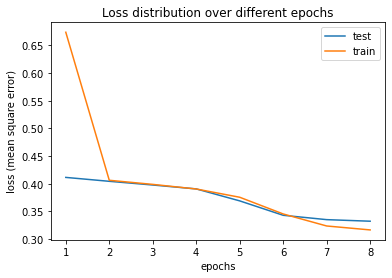

In [52]:
test_loss = history.history['val_loss']
train_loss = history.history['loss']
x = np.arange(1,n_epochs+1,1)

plt.plot(x,test_loss, label = "test")
plt.plot(x, train_loss, label = "train")

plt.xlabel('epochs')
plt.ylabel('loss (mean square error)')
plt.title('Loss distribution over different epochs')
plt.legend()

# Test minimum after 5 epochs

In [53]:
#model.compile(metrics = [tf.keras.metrics.MeanSquaredError()])

In [54]:
model.evaluate(test_atac.X.toarray(),  test_gex.X.toarray(), verbose=2)

24/24 - 1s - loss: 0.3322 - root_mean_squared_error: 0.5763 - 654ms/epoch - 27ms/step


[0.3321543335914612, 0.5763283371925354]

### Ideas to improve network
- using more epochs improves loss on train set but increases loss on test data (20% reached with 30 epochs on train data)
- using 5 epochs resulted in the lowest loss for test_data (batch size = 128)
- 9 epochs work best for batch size 32 (17 and 19 even better but very low improvement, not worth it)
- batch size 32 leads to slightly better prediction
- batch size 512: performance slightly worse than with 32, but much faster, best epoch count is 15 (no big change from 8)
- Huber loss and MeanAbsoluteError lead to many genes with prediction zero, MeanSquaredLogarithmicError has a similar effect (less severe)
- MeanSquaredLogarithmicError leads to smaller losses (but also smaller in general), mean_squared_error gets bigger
- Using MeanSquaredError leads to the best result in the scatter plot

### Train data

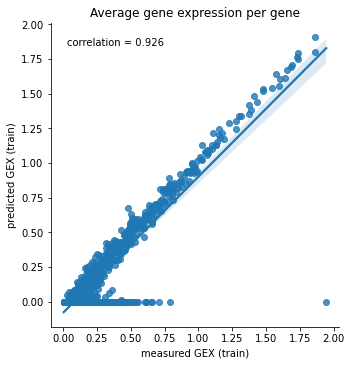

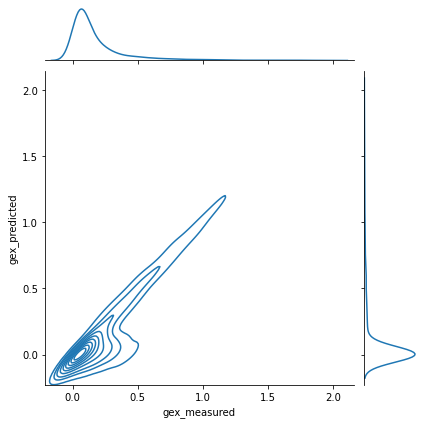

In [55]:
# average over all cells per genes

avg_gex_pred_train = np.mean(model(train_atac.X.toarray()).numpy(), axis = 0)
avg_gex_gt_train = np.array(np.mean(train_gex.X, axis = 0)).flatten()

avg_gex_train = pd.DataFrame({'gex_measured':avg_gex_gt_train, 'gex_predicted': avg_gex_pred_train})
pearson_cor = round(stats.pearsonr(avg_gex_gt_train, avg_gex_pred_train)[0], 3)

sns.lmplot(data = avg_gex_train, x = 'gex_measured', y = 'gex_predicted').set(title='Average gene expression per gene', xlabel = 'measured GEX (train)', ylabel = 'predicted GEX (train)')
plt.figtext(x = 0.2, y = 0.9, s = 'correlation = ' + str(pearson_cor))

sns.jointplot(data = avg_gex_train, x='gex_measured', y = 'gex_predicted', kind = 'kde')

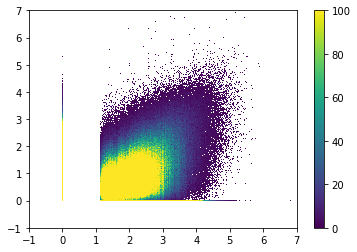

In [87]:
# all genes and cells
gex_pred_train = model(train_atac.X.toarray()).numpy().flatten()
gex_gt_train = train_gex.X.A.flatten()

def using_datashader(ax, x, y):

    df = pd.DataFrame(dict(x=x, y=y))
    dsartist = dsshow(
        df,
        ds.Point("x", "y"),
        ds.count(),
        vmin=0,
        vmax=100,
        norm="linear",
        aspect="auto",
        ax=ax,
    )

    plt.colorbar(dsartist)


fig, ax = plt.subplots()
using_datashader(ax, gex_gt_train, gex_pred_train)
plt.xlim([-1,7])
plt.ylim([-1,7])
plt.show()

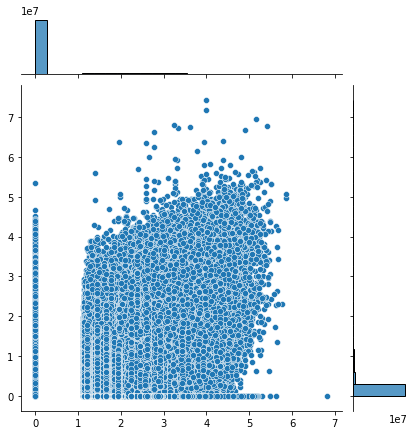

In [83]:
sns.jointplot(x = gex_gt_train, y = gex_pred_train)

In [57]:
# calculate euclidean distance
#pred_train_gex_array = model(train_atac.X.toarray()).numpy()
#meas_train_gex_array = train_gex.X.A

#euclidean = np.linalg.norm(meas_train_gex_array - pred_train_gex_array, ord = 2, axis = 1)

In [58]:
# calculate metric = measured_GEX - predicted_GEX

n_genes = len(train_gex.var.index)
n_cells = len(train_gex.obs.index)

pseudotime = np.repeat(np.array(train_atac.obs.GEX_pseudotime_order), n_genes)
metric = gex_gt_train - gex_pred_train
cell_types = train_atac.obs.cell_type.repeat(n_genes)

gex_df_train = pd.DataFrame({'cell_type': cell_types,'gex_predicted': gex_pred_train, 'gex_measured': gex_gt_train, 'pseudotime': pseudotime, 'metric' : metric})

gex_df_train.reset_index(inplace = True)
gex_df_train.rename(columns = {'index': 'cell_id'}, inplace = True)
gex_df_train

,cell_id,cell_type,gex_predicted,gex_measured,pseudotime,metric
0,TAATGGACATCGTTCT-14-s3d10,HSC,0.000000,0.000000,0.032048,0.000000
1,TAATGGACATCGTTCT-14-s3d10,HSC,0.000000,0.000000,0.032048,0.000000
2,TAATGGACATCGTTCT-14-s3d10,HSC,0.000000,0.000000,0.032048,0.000000
3,TAATGGACATCGTTCT-14-s3d10,HSC,0.000000,0.000000,0.032048,0.000000
4,TAATGGACATCGTTCT-14-s3d10,HSC,1.506513,2.109456,0.032048,0.602942
...,...,...,...,...,...,...
13778939,GGAACTAAGACAAAGT-13-s4d1,MK/E prog,0.818012,0.000000,0.287699,-0.818012
13778940,GGAACTAAGACAAAGT-13-s4d1,MK/E prog,0.000000,0.000000,0.287699,0.000000
13778941,GGAACTAAGACAAAGT-13-s4d1,MK/E prog,1.992848,3.654318,0.287699,1.661470
13778942,GGAACTAAGACAAAGT-13-s4d1,MK/E prog,0.051196,0.000000,0.287699,-0.051196


/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


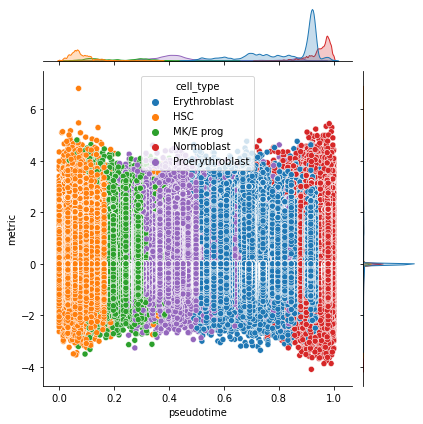

In [ ]:
sns.jointplot(data = gex_df_train, x = 'pseudotime', y = 'metric', hue = 'cell_type') #takes 5 min

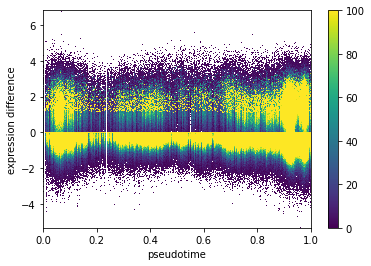

In [90]:
fig, ax = plt.subplots()
using_datashader(ax, pseudotime, metric)

plt.xlabel('pseudotime')
plt.ylabel('expression difference')
plt.titel('Difference in gene expression ')
plt.show()

In [92]:
Counter(adata_atac.obs.cell_type)

Counter({'MK/E prog': 528,
         'Erythroblast': 3607,
         'Normoblast': 1393,
         'HSC': 800,
         'Proerythroblast': 1145})

### Test data

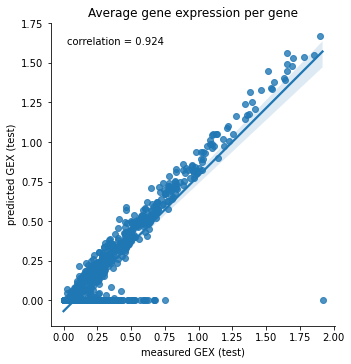

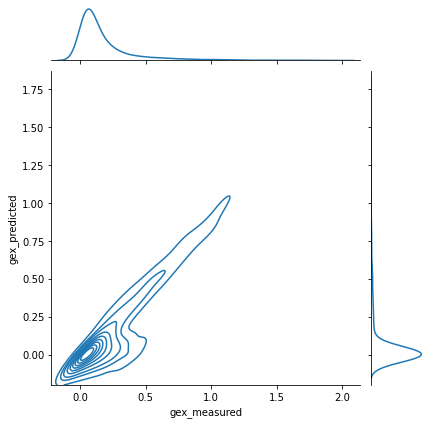

In [59]:
# average over all cells per genes

avg_gex_pred_test = np.mean(model(test_atac.X.toarray()).numpy(), axis = 0)
avg_gex_gt_test = np.array(np.mean(test_gex.X, axis = 0)).flatten()

avg_gex_test = pd.DataFrame({'gex_measured':avg_gex_gt_test, 'gex_predicted': avg_gex_pred_test})
pearson_cor = round(stats.pearsonr(avg_gex_gt_test, avg_gex_pred_test)[0], 3)

sns.lmplot(data = avg_gex_test, x = 'gex_measured', y = 'gex_predicted').set(title='Average gene expression per gene', xlabel = 'measured GEX (test)', ylabel = 'predicted GEX (test)')
plt.figtext(x = 0.2, y = 0.9, s = 'correlation = ' + str(pearson_cor))

sns.jointplot(data = avg_gex_test, x='gex_measured', y = 'gex_predicted', kind = 'kde')

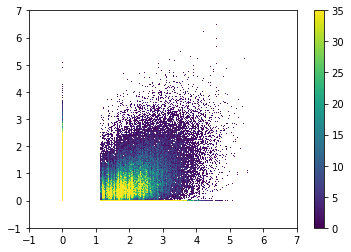

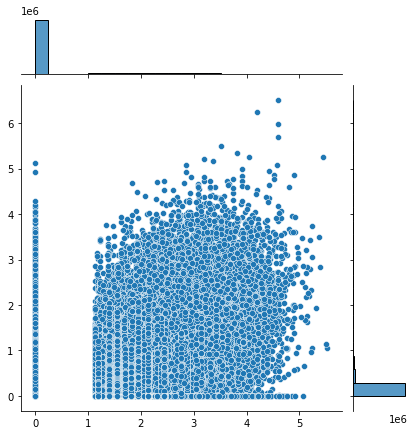

In [86]:
# compare gene expression measured vs predicted for each gene for each cell

gex_pred_test = model(test_atac.X.toarray()).numpy().flatten()
gex_gt_test = test_gex.X.A.flatten()

fig, ax = plt.subplots()
using_datashader(ax, gex_gt_test, gex_pred_test)
plt.xlim([-1,7])
plt.ylim([-1,7])
plt.show()

sns.jointplot(x=gex_gt_test, y = gex_pred_test)

In [63]:
# calculate metric = measured_GEX - predicted_GEX

n_genes_test = len(test_gex.var.index)
n_cells_test = len(test_gex.obs.index)

pseudotime_test = np.repeat(np.array(test_atac.obs.GEX_pseudotime_order), n_genes_test)
metric_test = gex_gt_test - gex_pred_test
cell_types = test_atac.obs.cell_type.repeat(n_genes_test)

gex_df_test = pd.DataFrame({'cell_type': cell_types,'gex_predicted': gex_pred_test, 'gex_measured': gex_gt_test, 'pseudotime': pseudotime_test, 'metric' : metric_test})

gex_df_test.reset_index(inplace = True)
gex_df_test.rename(columns = {'index': 'cell_id'}, inplace = True)
gex_df_test

,cell_id,cell_type,gex_predicted,gex_measured,pseudotime,metric
0,AGAACCAAGCTTCTCA-14-s4d8,MK/E prog,0.000000,0.000000,0.088363,0.000000
1,AGAACCAAGCTTCTCA-14-s4d8,MK/E prog,0.000000,0.000000,0.088363,0.000000
2,AGAACCAAGCTTCTCA-14-s4d8,MK/E prog,0.000000,0.000000,0.088363,0.000000
3,AGAACCAAGCTTCTCA-14-s4d8,MK/E prog,0.000000,0.000000,0.088363,0.000000
4,AGAACCAAGCTTCTCA-14-s4d8,MK/E prog,0.404327,0.000000,0.088363,-0.404327
...,...,...,...,...,...,...
1525755,AAACCGCGTACTTAGG-14-s4d8,Proerythroblast,0.000000,0.000000,0.379161,0.000000
1525756,AAACCGCGTACTTAGG-14-s4d8,Proerythroblast,0.000000,0.000000,0.379161,0.000000
1525757,AAACCGCGTACTTAGG-14-s4d8,Proerythroblast,0.863193,2.127158,0.379161,1.263965
1525758,AAACCGCGTACTTAGG-14-s4d8,Proerythroblast,0.000000,0.000000,0.379161,0.000000


/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


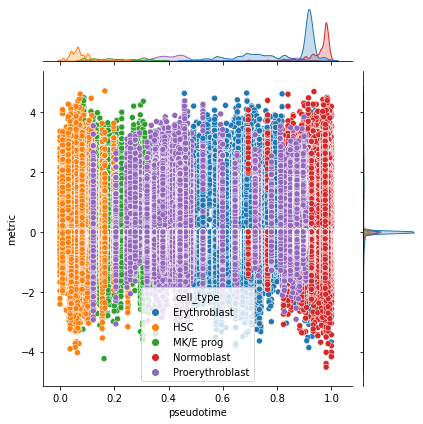

In [ ]:
sns.jointplot(data = gex_df_test, x = 'pseudotime', y = 'metric', hue = 'cell_type')

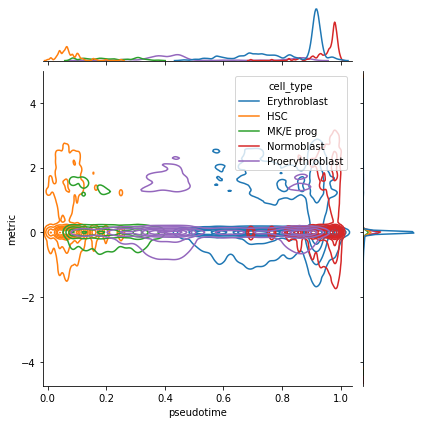

In [ ]:
sns.jointplot(data = gex_df_test, x = 'pseudotime', y = 'metric', hue = 'cell_type', kind = 'kde')